In [31]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from cv_paper_plots import accuracy, slope, analysis

from cv_paper_plots.style import letter_fontstyle

from importlib import reload

import scipy.stats as stats
from statsmodels.formula.api import ols

In [22]:
subjects = ['ec2', 'ec9', 'gp31', 'gp33']

In [23]:
with open(os.path.join(os.environ['HOME'], 'plots/model/data/frac_results.pkl'), 'rb') as f:
    deep_all, linear_all, _ = pickle.load(f, encoding='latin1')

d = np.load(os.path.join(os.environ['HOME'], 'plots/ds/data/dataset_chance.npz'))
chance = d['chance_data']
training_size = d['training_size']

In [24]:
other_linear_accuracy = {}
other_deep_accuracy = {}
for key in ['c', 'v', 'p', 'm']:
    other_linear_accuracy[key] = np.zeros((len(subjects), 3, 10))
    other_deep_accuracy[key] = np.zeros((len(subjects), 3, 10))
for ii, s in enumerate(subjects):
    for style in ['_lin', '']:
        f_string = 'plots/model/data/{}_{}_hg_a{}_model_output.pkl'.format(s, s, style)
        with open(os.path.join(os.environ['HOME'], f_string), 'rb') as f:
            dicts, dicts2, y_dims, has_data = pickle.load(f, encoding='latin1')
        indices_dicts2, y_hat_dicts2, logits_dicts2 = dicts2
        mats = analysis.indx_dict2conf_mat(indices_dicts2, y_dims)
        c_mat, v_mat, cv_mat = mats
        acc = analysis.conf_mat2accuracy(c_mat, v_mat, cv_mat)
        (c_accuracy, v_accuracy, cv_accuracy, accuracy_per_cv,
         p_accuracy, m_accuracy) = acc
        if style == '_lin':
            d = other_linear_accuracy
        else:
            d = other_deep_accuracy
        d['c'][ii, 2] = c_accuracy
        d['v'][ii, 2] = v_accuracy
        d['p'][ii, 2] = p_accuracy
        d['m'][ii, 2] = m_accuracy

In [25]:
fracs = sorted(deep_all.keys())

# CV Accuracy

Subject 1: p=0.005062032126267864, 0.005062032126267864, 0.005062032126267864
Subject 1: p=0.0022
Subject 2: p=0.21352435403618242, 0.005062032126267864, 0.005062032126267864


/home/jesse/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Subject 2: p=0.2738
Subject 3: p=0.005062032126267864, 0.005062032126267864, 0.005062032126267864
Subject 3: p=0.0018
Subject 4: p=0.005062032126267864, 0.005033508200606249, 0.005062032126267864
Subject 4: p=0.0027
all subject: p=1.4069613793016899e-06
The highest deep network accuracy for a single subject on the consonant vowel task is for Subject 1 which is 38.3$\pm$ 2.9\% (21.5 times chance, 1.8\%) and 23.6$\pm$ 2.1\% (13.2 times chance, 1.8\%) for logistic regression and deep networks respectively, which is a 63.1\% improvement. Mean consonant vowel classification accuracy across subjects (XX way) with deep networks is 19.9 $\pm$ 12.6\%. For logistic regression, it is 13.1 $\pm$ 7.4\%.
Subject 1: p=0.005062032126267864, 0.005062032126267864, 0.005062032126267864
Subject 1: p=0.0014
Subject 2: p=0.1688069535565081, 0.005062032126267864, 0.005062032126267864
Subject 2: p=0.1748
Subject 3: p=0.005062032126267864, 0.005062032126267864, 0.005062032126267864
Subject 3: p=0.0023
Subject 

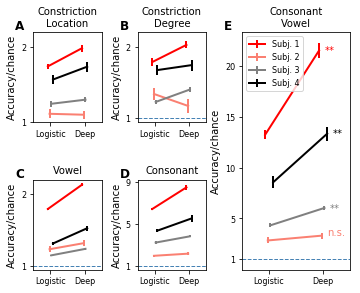

In [26]:
reload(accuracy)
reload(slope)
plt.close()
f = plt.figure(figsize=(5, 4))

le = .1
re = .02
te = .1
be = .075
h_gap = .1
v_gap = .2

cv_w = .3
big_h = (1. - te - be)
little_h = (1. - te - be - v_gap) / 2.
w = (1. - le - cv_w - h_gap - h_gap - re) / 2.

p_m_y = be + little_h + v_gap
ax_p = f.add_axes([le, p_m_y, w, little_h])
ax_m = f.add_axes([le + w + h_gap, p_m_y, w, little_h])

ax_v = f.add_axes([le, be, w, little_h])
ax_c = f.add_axes([le + w + h_gap, be, w, little_h])

ax_cv = f.add_axes([1. - re - cv_w, be, cv_w, big_h])

key = fracs[-1]

accuracy.plot_cv_accuracy(subjects, deep_all[key], linear_all[key], chance[0, :, -1], ax_cv, legend=True,
                          show_significance=True)

accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['c'], other_linear_accuracy['c'],
                          chance[1, :, -1], ax_c, 'Consonant', False, ymax=9.2)
accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['v'], other_linear_accuracy['v'],
                          chance[2, :, -1], ax_v, 'Vowel', False, ymax=2.2)

accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['p'], other_linear_accuracy['p'],
                          chance[3, :, -1], ax_p, 'Constriction\nLocation', False, ymax=2.2)
accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['m'], other_linear_accuracy['m'],
                          chance[4, :, -1], ax_m, 'Constriction\nDegree', False, ymax=2.2)

x0 = le - .05
y0 = p_m_y + little_h + .01
x1 = le + w + h_gap - .05
y1 = be + little_h + .01
x2 = 1. - re - cv_w - .05

f.text(x0, y0, 'A', **letter_fontstyle)
f.text(x1, y0, 'B', **letter_fontstyle)
f.text(x0, y1, 'C', **letter_fontstyle)
f.text(x1, y1, 'D', **letter_fontstyle)
f.text(x2, y0, 'E', **letter_fontstyle)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/accuracy.pdf'))
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/accuracy.png'), dpi=300)

# ANOVA improvement dependence on task

In [27]:
cv_diffs = []
c_diffs = []
other_diffs = []

da = deep_all[key][:, -1]
la = linear_all[key][:, -1]
ca = chance[0, :, -1].mean(axis=-1)
cv_diffs = ((da - la) / ca).ravel()

da = other_deep_accuracy['c'][:, -1]
la = other_linear_accuracy['c'][:, -1]
ca = chance[1, :, -1].mean(axis=-1)
c_diffs = ((da - la) / ca).ravel()

for ii, t in enumerate(['v', 'p', 'm']):
    da = other_deep_accuracy[t][:, -1]
    la = other_linear_accuracy[t][:, -1]
    ca = chance[ii+2, :, -1].mean(axis=-1)
    other_diffs.extend(((da - la) / ca).ravel())
other_diffs = np.array(other_diffs)

In [28]:
stats.f_oneway(cv_diffs, c_diffs, other_diffs)

F_onewayResult(statistic=79.984476745962965, pvalue=3.7224111580503916e-26)

In [32]:
ys = np.concatenate((cv_diffs, c_diffs, other_diffs))
xs = np.concatenate((np.ones_like(cv_diffs), 2*np.ones_like(c_diffs), 3*np.ones_like(other_diffs)))

df = pd.DataFrame.from_dict({'x': xs, 'y':ys})
formula = 'y ~ C(x)'
lm = ols(formula, df)
fit = lm.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     79.98
Date:                Tue, 20 Feb 2018   Prob (F-statistic):           3.72e-26
Time:                        16:35:32   Log-Likelihood:                -376.40
No. Observations:                 200   AIC:                             758.8
Df Residuals:                     197   BIC:                             768.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.8218      0.253     15.098      

# ANOVA deep accuracy dependence on subject

In [30]:
s1 = []
s2 = []
s3 = []
s4 = []

da = deep_all[key][:, -1]
la = linear_all[key][:, -1]
ca = chance[0, :, -1].mean(axis=-1)
cv_diffs = ((da - la) / ca)
for s, x in zip([s1, s2, s3, s4], cv_diffs):
    s.extend(x.ravel())

for ii, t in enumerate(['c', 'v', 'p', 'm']):
    da = other_deep_accuracy[t][:, -1]
    la = other_linear_accuracy[t][:, -1]
    ca = chance[ii+1, :, -1].mean(axis=-1)
    other_diffs = ((da - la) / ca)
    for s, x in zip([s1, s2, s3, s4], other_diffs):
        s.extend(x.ravel())
s1, s2, s3, s4 = [np.array(s).ravel() for s in [s1, s2, s3, s4]]

In [31]:
stats.f_oneway(s1, s2, s3, s4)

F_onewayResult(statistic=10.385808751340139, pvalue=2.2521291716222334e-06)

# Improvement depedence on baseline

# CV Slope

3.1323836087 0.596110561972 5.02547741709e-07 0.553983542366
6.38846636748 0.791776366103 4.99049030788e-14 0.647123236354

1.50213850904 0.378168248695 0.00289050195082 0.482834715125
2.37880122793 0.494590391146 5.89968111821e-05 0.548884949707

0.323201761913 0.287719619617 0.0258038307091 0.141262338911
0.774446734837 0.575407668776 1.51486873566e-06 0.144538805454

5.14109752119 0.457297804275 0.000239466048615 1.3127972968
10.209351895 0.720386019724 8.66305904584e-11 1.29065834477

0.000428433864638
0.465775170163
0.0549729455434
0.0137118532013
Deep networks scale better with dataset size than logistic regresion with an improvement of 1.9 $\pm$ 3.0  and 1.1 $\pm$ 1.5 over chance per 1000 training samples respectively. This improvement is summarized across subjects in Fig \ref{fig:slope}B. For the subject with highest accuracy (Subject 1), the change in accuracy over chance per 1000 training examples for deep networks and logistic regression are 2.3 $\pm$ 2.9 and 1.2 $\pm$ 1.4 r

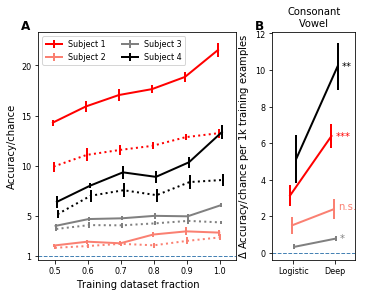

In [7]:
# reload(accuracy)
reload(slope)
plt.close()
f = plt.figure(figsize=(5, 4))

le = .1
re = .02
te = .1
be = .11
h_gap = .1

w = .55
h = 1. - te - be

ax_lines = f.add_axes([le, be, w, h])
ax_slopes = f.add_axes([le + w + h_gap, be, 1. - w - h_gap - le - re, h])

key = fracs[-1]

slope.plot_cv_slope(subjects, deep_all, linear_all, chance[0], training_size, fracs, (ax_lines, ax_slopes),
                    legend=True)

x0 = .05
y0 = 1. - te + .01
x1 = le + w + h_gap - .05

f.text(x0, y0, 'A', **letter_fontstyle)
f.text(x1, y0, 'B', **letter_fontstyle)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/slope.pdf'))
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/slope.png'), dpi=300)